In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import pickle
import os

file_path = '/content/drive/My Drive/MIDOG_Challenge_2022_png/midog_patches_reinhard_full.pkl'

# Load the pickle file
with open(file_path, 'rb') as f:
    data = pickle.load(f)

print(type(data))
print(data.keys())


<class 'dict'>
dict_keys(['mitotic figure', 'not mitotic figure'])


In [2]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import pandas as pd
from collections import defaultdict

base_dir = '/content/drive/My Drive/MIDOG_Challenge_2022_png'

In [7]:
def create_annotation_to_cancer_mapping(annotations_json):
    """
    Create a mapping from annotation IDs to cancer types based on image IDs.

    Args:
        annotations_json: Path to the JSON annotation file

    Returns:
        Dictionary mapping annotation ID to (cancer_type, species) tuple
    """
    with open(annotations_json, 'r') as f:
        coco_data = json.load(f)

    # Define cancer type ranges based on image IDs
    cancer_mappings = [
        ((1, 150), "breast_cancer", "human"),
        ((151, 194), "lung_carcinoma", "canine"),
        ((195, 249), "lymphoma", "canine"),
        ((250, 299), "mast_cell_tumor", "canine"),
        ((300, 354), "neuroendocrine_tumor", "human"),
        ((355, 405), "melanoma", "human")
    ]

    # Create annotation ID to cancer type mapping
    annotation_to_cancer = {}
    for ann in coco_data['annotations']:
        image_id = ann['image_id']
        # Find matching cancer type
        for (start, end), cancer, species in cancer_mappings:
            if start <= image_id <= end:
                annotation_to_cancer[ann['id']] = (cancer, species, image_id)
                break

    return annotation_to_cancer

# Create the mapping
annotations_json = os.path.join(base_dir, 'MIDOG2022_training_png.json')
annotation_to_cancer = create_annotation_to_cancer_mapping(annotations_json)

# File path
file_path = '/content/drive/My Drive/MIDOG_Challenge_2022_png/midog_patches_reinhard_full.pkl'

# Load the pickle file
with open(file_path, 'rb') as f:
    all_patches = pickle.load(f)

# Add cancer type information
for category in all_patches:
    for patch in all_patches[category]:
        annotation_id = patch['annotation_id']
        if annotation_id in annotation_to_cancer:
            cancer_type, species, image_id = annotation_to_cancer[annotation_id]
            patch['cancer_type'] = cancer_type
            patch['species'] = species
            patch['image_id'] = image_id
        else:
            patch['cancer_type'] = 'unknown'
            patch['species'] = 'unknown'

# Save
with open('midog_patches_with_cancer_info.pkl', 'wb') as f:
    pickle.dump(all_patches, f)


# Save to Google Drive
output_path = '/content/drive/My Drive/MIDOG_Challenge_2022_png/midog_patches_with_cancer_info.pkl'
with open(output_path, 'wb') as f:
    pickle.dump(all_patches, f)



---

### **INTENSITY-BASED FEATURES**
* Mean intensity – Average pixel intensity in the patch  
* Standard deviation of intensity – Variation/contrast in brightness  
* Entropy – Randomness of intensity values; high for complex textures  
* Intensity skewness – Symmetry of brightness distribution  
* Max–Min intensity – Peak contrast  

---

### **STAIN/COLOR-BASED FEATURES**
* Mean hematoxylin intensity – Nucleus content (lower for mitosis)  
* Mean eosin intensity – Cytoplasm content  
* Hematoxylin:Eosin ratio – Distinguishes nuclear-rich areas  

---

### **TEXTURE-BASED FEATURES**
* GLCM contrast – Texture strength  
* GLCM correlation – Pixel dependency patterns  
* GLCM energy – Uniformity of texture  
* GLCM homogeneity – Smoothness or uniform spread  
* LBP histogram uniformity – Pattern of pixel neighborhoods  

---

### **MORPHOLOGICAL/SHAPE FEATURES**
* Area of the segmented nucleus – Size of mitotic region  
* Perimeter – Boundary length  
* Circularity – 4π (Area / Perimeter)^2  
* Eccentricity – Oval-ness; 0 = circle, 1 = line  
* Solidity – Ratio of area to convex hull (compactness)  

---

### **EDGE & STRUCTURAL FEATURES**
* Canny edge pixel count – Edges = strong signal boundaries  
* Sobel gradient magnitude mean – Overall edge strength in patch  

---


In [ ]:
!pip install -U scikit-image

In [8]:
import numpy as np
import cv2
from skimage.color import rgb2hed, rgb2gray
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops
from skimage.filters import sobel
from skimage.measure import label, regionprops
from skimage.util import img_as_ubyte
from scipy.stats import skew, entropy

def extract_features_from_patch(patch):
    features = []

    # Convert to grayscale and uint8
    gray = rgb2gray(patch)
    gray_u8 = img_as_ubyte(gray)

    # --- INTENSITY FEATURES ---
    features.append(np.mean(gray))                            # 1. Mean intensity
    features.append(np.std(gray))                             # 2. Std intensity
    features.append(entropy(np.histogram(gray_u8, bins=256)[0] + 1e-6))  # 3. Entropy
    features.append(skew(gray.flatten()))                     # 4. Skewness
    features.append(np.max(gray) - np.min(gray))              # 5. Max - Min

    # --- STAIN FEATURES (after H&E separation) ---
    hed = rgb2hed(patch)
    h = hed[:, :, 0]
    e = hed[:, :, 1]
    h_mean = np.mean(h)
    e_mean = np.mean(e)
    features.append(h_mean)                                   # 6. Mean hematoxylin
    features.append(e_mean)                                   # 7. Mean eosin
    features.append(h_mean / (e_mean + 1e-8))                 # 8. H:E ratio

    # --- TEXTURE FEATURES (GLCM + LBP) ---

    glcm = graycomatrix(gray_u8, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    features.append(graycoprops(glcm, 'contrast')[0, 0])
    features.append(graycoprops(glcm, 'correlation')[0, 0])
    features.append(graycoprops(glcm, 'energy')[0, 0])
    features.append(graycoprops(glcm, 'homogeneity')[0, 0])


    lbp = local_binary_pattern(gray_u8, P=8, R=1, method='uniform')
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), density=True)
    lbp_uniformity = -np.sum(lbp_hist * np.log(lbp_hist + 1e-8))  # 13. LBP histogram uniformity
    features.append(lbp_uniformity)

    # --- MORPHOLOGICAL FEATURES ---
    h_clipped = np.clip(h, -1, 1)
    _, binary = cv2.threshold(img_as_ubyte(h_clipped), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    labeled = label(binary)
    props = regionprops(labeled)

    if props:
        obj = props[0]
        area = obj.area
        perimeter = obj.perimeter
        features.append(area)                                 # 14. Area
        features.append(perimeter)                            # 15. Perimeter
        circularity = 4 * np.pi * area / (perimeter**2) if perimeter > 0 else 0
        features.append(circularity)                          # 16. Circularity
        features.append(obj.eccentricity)                     # 17. Eccentricity
        features.append(obj.solidity)                         # 18. Solidity
    else:
        features.extend([0, 0, 0, 0, 0])

    # --- EDGE FEATURES ---
    canny = cv2.Canny(gray_u8, 100, 200)
    features.append(np.sum(canny > 0))                        # 19. Edge pixel count (Canny)
    sob = sobel(gray)
    features.append(np.mean(sob))                             # 20. Sobel gradient mean

    return features


#Extract Features

In [11]:
import pickle
import pandas as pd
from tqdm import tqdm
from skimage.measure import label


# Load patch data
with open('/content/drive/My Drive/MIDOG_Challenge_2022_png/midog_patches_with_cancer_info.pkl', 'rb') as f:
    all_patches = pickle.load(f)

# Lists to store everything
features, labels, metas = [], [], []

print("Extracting features...")
for category, patches in all_patches.items():
    target_label = 1 if category == "mitotic figure" else 0
    for patch in tqdm(patches):
        feat = extract_features_from_patch(patch['patch'])
        features.append(feat)
        labels.append(target_label)
        metas.append({
            'annotation_id': patch['annotation_id'],
            'image_id': patch['image_id'],
            'cancer_type': patch['cancer_type'],
            'species': patch['species']
        })


# Build DataFrame
X = pd.DataFrame(features, columns=[f'feat_{i}' for i in range(len(features[0]))])
y = pd.Series(labels, name='label')
meta = pd.DataFrame(metas)

# Final dataset
full_dataset = pd.concat([X, y, meta], axis=1)


Extracting features...


100%|██████████| 11051/11051 [02:14<00:00, 82.19it/s]


#Save Features, Labels, Metadata to CSV

In [12]:
import pandas as pd

# Create DataFrames
X = pd.DataFrame(features, columns=[f'feat_{i}' for i in range(len(features[0]))])
y = pd.Series(labels, name='label')
meta = pd.DataFrame(metas)

# Combine all into one dataset
full_dataset = pd.concat([X, y, meta], axis=1)

# Save to Google Drive
output_path = '/content/drive/My Drive/MIDOG_Challenge_2022_png/midog_features_full.csv'
full_dataset.to_csv(output_path, index=False)

print("Saved to:", output_path)


Saved to: /content/drive/My Drive/MIDOG_Challenge_2022_png/midog_features_full.csv


#Load and split breast vs multi-cancer data

In [3]:
import pandas as pd

# Load the full dataset
csv_path = '/content/drive/My Drive/MIDOG_Challenge_2022_png/midog_features_full.csv'
df = pd.read_csv(csv_path)

# Split into breast and multi
breast_df = df[df['cancer_type'] == 'breast_cancer']
multi_df = df[df['cancer_type'] != 'breast_cancer']

# Check shapes
print("Breast samples:", breast_df.shape)
print("Multi-cancer samples:", multi_df.shape)


Breast samples: (4435, 25)
Multi-cancer samples: (16117, 25)


# Breast Train → Breast Test


In [6]:
from sklearn.model_selection import train_test_split

# Features and labels
X = breast_df.drop(columns=['label', 'annotation_id', 'image_id', 'cancer_type', 'species'])
y = breast_df['label']

# Step 1: Split off the test set (15%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)

# Check sizes
print(f"Train size: {X_train.shape}")
print(f"Test size: {X_test.shape}")

Train size: (3769, 20)
Test size: (666, 20)


In [7]:
# Create stratification key
strat_key_train = y_train  # since breast is one domain, only label


## Random Forest

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import numpy as np

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_f1 = 0
best_model = None
best_params = None

for n in param_grid['n_estimators']:
    for d in param_grid['max_depth']:
        for s in param_grid['min_samples_split']:
            fold_scores = []
            for train_idx, val_idx in skf.split(X_train, strat_key_train):
                X_tr_raw, X_val_raw = X_train.iloc[train_idx], X_train.iloc[val_idx]
                y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

                scaler = StandardScaler()
                X_tr = scaler.fit_transform(X_tr_raw)
                X_val = scaler.transform(X_val_raw)

                model = RandomForestClassifier(
                    n_estimators=n,
                    max_depth=d,
                    min_samples_split=s,
                    random_state=42
                )
                model.fit(X_tr, y_tr)
                y_val_pred = model.predict(X_val)
                f1 = f1_score(y_val, y_val_pred)
                fold_scores.append(f1)

            avg_f1 = np.mean(fold_scores)
            print(f"Random Forest: n={n}, depth={d}, split={s} → Avg F1 = {avg_f1:.4f}")

            if avg_f1 > best_f1:
                best_f1 = avg_f1
                best_model = model
                best_params = (n, d, s)

print("\nBest RF Params:", best_params)
print(f"Best CV F1: {best_f1:.4f}")

# Final test evaluation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_test_pred = best_model.predict(X_test_scaled)
print("Random Forest Test Classification Report:")
print(classification_report(y_test, y_test_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))


Random Forest: n=100, depth=None, split=2 → Avg F1 = 0.3717
Random Forest: n=100, depth=None, split=5 → Avg F1 = 0.3697
Random Forest: n=100, depth=10, split=2 → Avg F1 = 0.3313
Random Forest: n=100, depth=10, split=5 → Avg F1 = 0.3460
Random Forest: n=100, depth=20, split=2 → Avg F1 = 0.3747
Random Forest: n=100, depth=20, split=5 → Avg F1 = 0.3782
Random Forest: n=200, depth=None, split=2 → Avg F1 = 0.3803
Random Forest: n=200, depth=None, split=5 → Avg F1 = 0.3843
Random Forest: n=200, depth=10, split=2 → Avg F1 = 0.3387
Random Forest: n=200, depth=10, split=5 → Avg F1 = 0.3360
Random Forest: n=200, depth=20, split=2 → Avg F1 = 0.3781
Random Forest: n=200, depth=20, split=5 → Avg F1 = 0.3941

Best RF Params: (200, 20, 5)
Best CV F1: 0.3941
Random Forest Test Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.86      0.75       408
           1       0.59      0.33      0.42       258

    accuracy                           0.

# Naive Bayes

In [23]:
from sklearn.naive_bayes import GaussianNB

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_scores = []
for train_idx, val_idx in skf.split(X_train, strat_key_train):
    X_tr_raw, X_val_raw = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    scaler = StandardScaler()
    X_tr = scaler.fit_transform(X_tr_raw)
    X_val = scaler.transform(X_val_raw)

    model = GaussianNB()
    model.fit(X_tr, y_tr)
    y_val_pred = model.predict(X_val)
    f1 = f1_score(y_val, y_val_pred)
    fold_scores.append(f1)

avg_f1 = np.mean(fold_scores)
print(f"\nNaïve Bayes CV Avg F1: {avg_f1:.4f}")

# Final test eval
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = GaussianNB()
model.fit(X_train_scaled, y_train)
y_test_pred = model.predict(X_test_scaled)

print("Naïve Bayes Test Classification Report:")
print(classification_report(y_test, y_test_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))



Naïve Bayes CV Avg F1: 0.5059
Naïve Bayes Test Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.50      0.58       408
           1       0.45      0.66      0.53       258

    accuracy                           0.56       666
   macro avg       0.57      0.58      0.56       666
weighted avg       0.60      0.56      0.56       666

Confusion Matrix:
[[202 206]
 [ 89 169]]


# SVM

In [24]:
from sklearn.svm import SVC

param_grid = {
    'C': [1, 10],
    'gamma': ['scale', 0.01, 0.1]
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_f1 = 0
best_model = None
best_params = None

for C in param_grid['C']:
    for gamma in param_grid['gamma']:
        fold_scores = []
        for train_idx, val_idx in skf.split(X_train, strat_key_train):
            X_tr_raw, X_val_raw = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

            scaler = StandardScaler()
            X_tr = scaler.fit_transform(X_tr_raw)
            X_val = scaler.transform(X_val_raw)

            model = SVC(C=C, kernel='rbf', gamma=gamma, random_state=42)
            model.fit(X_tr, y_tr)
            y_val_pred = model.predict(X_val)
            f1 = f1_score(y_val, y_val_pred)
            fold_scores.append(f1)

        avg_f1 = np.mean(fold_scores)
        print(f"SVM: C={C}, gamma={gamma} → Avg F1 = {avg_f1:.4f}")

        if avg_f1 > best_f1:
            best_f1 = avg_f1
            best_model = model
            best_params = (C, gamma)

print("\nBest SVM Params:", best_params)
print(f"Best CV F1: {best_f1:.4f}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_test_pred = best_model.predict(X_test_scaled)
print("SVM Test Classification Report:")
print(classification_report(y_test, y_test_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))


SVM: C=1, gamma=scale → Avg F1 = 0.2826
SVM: C=1, gamma=0.01 → Avg F1 = 0.0172
SVM: C=1, gamma=0.1 → Avg F1 = 0.3604
SVM: C=10, gamma=scale → Avg F1 = 0.4343
SVM: C=10, gamma=0.01 → Avg F1 = 0.2616
SVM: C=10, gamma=0.1 → Avg F1 = 0.4467

Best SVM Params: (10, 0.1)
Best CV F1: 0.4467
SVM Test Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.72      0.70       408
           1       0.51      0.46      0.49       258

    accuracy                           0.62       666
   macro avg       0.60      0.59      0.59       666
weighted avg       0.62      0.62      0.62       666

Confusion Matrix:
[[295 113]
 [139 119]]


# Feature Importance (RF)

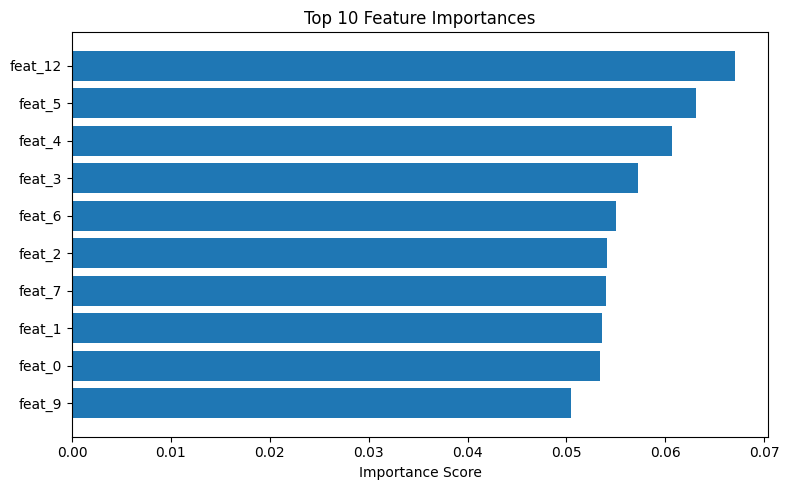

feat_12: 0.067059
feat_5: 0.063092
feat_4: 0.060647
feat_3: 0.057232
feat_6: 0.055037
feat_2: 0.054070
feat_7: 0.054045
feat_1: 0.053623
feat_0: 0.053429
feat_9: 0.050445


In [9]:
#Feature Importance Random Forest
importances = best_model.feature_importances_
feature_names = X_train.columns

# Plot top 10 features
top_indices = np.argsort(importances)[-10:]
plt.figure(figsize=(8, 5))
plt.barh(range(10), importances[top_indices], align='center')
plt.yticks(range(10), [feature_names[i] for i in top_indices])
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

top_features = sorted(zip(importances, feature_names), reverse=True)[:10]
for importance, name in top_features:
    print(f"{name}: {importance:.6f}")


#Breast train → Multi test

In [27]:
from sklearn.model_selection import train_test_split

# Training set: breast data
X_train = breast_df.drop(columns=['label', 'annotation_id', 'image_id', 'cancer_type', 'species'])
y_train = breast_df['label']

# Test set: multi-organ data
X_test = multi_df.drop(columns=['label', 'annotation_id', 'image_id', 'cancer_type', 'species'])
y_test = multi_df['label']

# Check sizes
print(f"Train size (Breast): {X_train.shape}")
print(f"Test size (Multi):  {X_test.shape}")


Train size (Breast): (4435, 20)
Test size (Multi):  (16117, 20)


In [28]:
# Create stratification key
strat_key_train = y_train  # since breast is one domain, only label

#Random Forest

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import numpy as np

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_f1 = 0
best_model = None
best_params = None

for n in param_grid['n_estimators']:
    for d in param_grid['max_depth']:
        for s in param_grid['min_samples_split']:
            fold_scores = []
            for train_idx, val_idx in skf.split(X_train, strat_key_train):
                X_tr_raw, X_val_raw = X_train.iloc[train_idx], X_train.iloc[val_idx]
                y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

                scaler = StandardScaler()
                X_tr = scaler.fit_transform(X_tr_raw)
                X_val = scaler.transform(X_val_raw)

                model = RandomForestClassifier(
                    n_estimators=n,
                    max_depth=d,
                    min_samples_split=s,
                    random_state=42
                )
                model.fit(X_tr, y_tr)
                y_val_pred = model.predict(X_val)
                f1 = f1_score(y_val, y_val_pred)
                fold_scores.append(f1)

            avg_f1 = np.mean(fold_scores)
            print(f"Random Forest: n={n}, depth={d}, split={s} → Avg F1 = {avg_f1:.4f}")

            if avg_f1 > best_f1:
                best_f1 = avg_f1
                best_model = model
                best_params = (n, d, s)

print("\nBest RF Params:", best_params)
print(f"Best CV F1: {best_f1:.4f}")

# Final test evaluation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_test_pred = best_model.predict(X_test_scaled)
print("Random Forest Test Classification Report:")
print(classification_report(y_test, y_test_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))


Random Forest: n=100, depth=None, split=2 → Avg F1 = 0.3829
Random Forest: n=100, depth=None, split=5 → Avg F1 = 0.3808
Random Forest: n=100, depth=10, split=2 → Avg F1 = 0.3319
Random Forest: n=100, depth=10, split=5 → Avg F1 = 0.3363
Random Forest: n=100, depth=20, split=2 → Avg F1 = 0.3898
Random Forest: n=100, depth=20, split=5 → Avg F1 = 0.3819
Random Forest: n=200, depth=None, split=2 → Avg F1 = 0.3952
Random Forest: n=200, depth=None, split=5 → Avg F1 = 0.3792
Random Forest: n=200, depth=10, split=2 → Avg F1 = 0.3258
Random Forest: n=200, depth=10, split=5 → Avg F1 = 0.3263
Random Forest: n=200, depth=20, split=2 → Avg F1 = 0.3819
Random Forest: n=200, depth=20, split=5 → Avg F1 = 0.3720

Best RF Params: (200, None, 2)
Best CV F1: 0.3952
Random Forest Test Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.79      0.63      8337
           1       0.50      0.23      0.31      7780

    accuracy                           

# Naive Bayes

In [30]:
from sklearn.naive_bayes import GaussianNB

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_f1 = 0
best_model = None
best_params = None
fold_scores = []

for train_idx, val_idx in skf.split(X_train, strat_key_train):
    X_tr_raw, X_val_raw = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    scaler = StandardScaler()
    X_tr = scaler.fit_transform(X_tr_raw)
    X_val = scaler.transform(X_val_raw)

    model = GaussianNB()
    model.fit(X_tr, y_tr)
    y_val_pred = model.predict(X_val)
    f1 = f1_score(y_val, y_val_pred)
    fold_scores.append(f1)

avg_f1 = np.mean(fold_scores)
print(f"\nNaïve Bayes CV Avg F1: {avg_f1:.4f}")

# Final test eval
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = GaussianNB()
model.fit(X_train_scaled, y_train)
y_test_pred = model.predict(X_test_scaled)

print("Naïve Bayes Test Classification Report:")
print(classification_report(y_test, y_test_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))



Naïve Bayes CV Avg F1: 0.5021
Naïve Bayes Test Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.24      0.34      8337
           1       0.50      0.83      0.63      7780

    accuracy                           0.52     16117
   macro avg       0.55      0.53      0.48     16117
weighted avg       0.55      0.52      0.48     16117

Confusion Matrix:
[[1979 6358]
 [1334 6446]]


#SVM

In [31]:
from sklearn.svm import SVC

param_grid = {
    'C': [1, 10],
    'gamma': ['scale', 0.01, 0.1]
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_f1 = 0
best_model = None
best_params = None

for C in param_grid['C']:
    for gamma in param_grid['gamma']:
        fold_scores = []
        for train_idx, val_idx in skf.split(X_train, strat_key_train):
            X_tr_raw, X_val_raw = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

            scaler = StandardScaler()
            X_tr = scaler.fit_transform(X_tr_raw)
            X_val = scaler.transform(X_val_raw)

            model = SVC(C=C, kernel='rbf', gamma=gamma, random_state=42)
            model.fit(X_tr, y_tr)
            y_val_pred = model.predict(X_val)
            f1 = f1_score(y_val, y_val_pred)
            fold_scores.append(f1)

        avg_f1 = np.mean(fold_scores)
        print(f"SVM: C={C}, gamma={gamma} → Avg F1 = {avg_f1:.4f}")

        if avg_f1 > best_f1:
            best_f1 = avg_f1
            best_model = model
            best_params = (C, gamma)

print("\nBest SVM Params:", best_params)
print(f"Best CV F1: {best_f1:.4f}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_test_pred = best_model.predict(X_test_scaled)
print("SVM Test Classification Report:")
print(classification_report(y_test, y_test_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))


SVM: C=1, gamma=scale → Avg F1 = 0.2971
SVM: C=1, gamma=0.01 → Avg F1 = 0.0371
SVM: C=1, gamma=0.1 → Avg F1 = 0.3601
SVM: C=10, gamma=scale → Avg F1 = 0.4291
SVM: C=10, gamma=0.01 → Avg F1 = 0.2703
SVM: C=10, gamma=0.1 → Avg F1 = 0.4526

Best SVM Params: (10, 0.1)
Best CV F1: 0.4526
SVM Test Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.82      0.64      8337
           1       0.51      0.19      0.28      7780

    accuracy                           0.52     16117
   macro avg       0.51      0.51      0.46     16117
weighted avg       0.51      0.52      0.47     16117

Confusion Matrix:
[[6869 1468]
 [6276 1504]]


# Multi Train --> Breast Test

In [47]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

# Create stratification key for label + cancer type
multi_df['strat_key'] = multi_df['label'].astype(str) + '_' + multi_df['cancer_type']

# Training set (multi-organ)
X_train = multi_df.drop(columns=['label', 'annotation_id', 'image_id', 'cancer_type', 'species', 'strat_key'])
y_train = multi_df['label']
strat_key_train = multi_df['strat_key']

# Test set (breast)
X_test = breast_df.drop(columns=['label', 'annotation_id', 'image_id', 'cancer_type', 'species'])
y_test = breast_df['label']

# Just for confirmation
print("Multi Train → Breast Test")
print("Train (multi):", X_train.shape)
print("Test  (breast):", X_test.shape)


Multi Train → Breast Test
Train (multi): (16118, 20)
Test  (breast): (4435, 20)


<ipython-input-47-760eb55d05ae>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multi_df['strat_key'] = multi_df['label'].astype(str) + '_' + multi_df['cancer_type']


# Naive Bayes

In [38]:
from sklearn.naive_bayes import GaussianNB

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_f1 = 0
best_model = None
best_params = None
fold_scores = []

for train_idx, val_idx in skf.split(X_train, strat_key_train):
    X_tr_raw, X_val_raw = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    scaler = StandardScaler()
    X_tr = scaler.fit_transform(X_tr_raw)
    X_val = scaler.transform(X_val_raw)

    model = GaussianNB()
    model.fit(X_tr, y_tr)
    y_val_pred = model.predict(X_val)
    f1 = f1_score(y_val, y_val_pred)
    fold_scores.append(f1)

avg_f1 = np.mean(fold_scores)
print(f"\nNaïve Bayes CV Avg F1: {avg_f1:.4f}")

# Final test eval
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = GaussianNB()
model.fit(X_train_scaled, y_train)
y_test_pred = model.predict(X_test_scaled)

print("Naïve Bayes Test Classification Report:")
print(classification_report(y_test, y_test_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))



Naïve Bayes CV Avg F1: 0.6337
Naïve Bayes Test Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.67      0.65      2714
           1       0.43      0.39      0.41      1721

    accuracy                           0.56      4435
   macro avg       0.53      0.53      0.53      4435
weighted avg       0.56      0.56      0.56      4435

Confusion Matrix:
[[1822  892]
 [1048  673]]


#Random Forest

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import numpy as np

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_f1 = 0
best_model = None
best_params = None

for n in param_grid['n_estimators']:
    for d in param_grid['max_depth']:
        for s in param_grid['min_samples_split']:
            fold_scores = []
            for train_idx, val_idx in skf.split(X_train, strat_key_train):
                X_tr_raw, X_val_raw = X_train.iloc[train_idx], X_train.iloc[val_idx]
                y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

                scaler = StandardScaler()
                X_tr = scaler.fit_transform(X_tr_raw)
                X_val = scaler.transform(X_val_raw)

                model = RandomForestClassifier(
                    n_estimators=n,
                    max_depth=d,
                    min_samples_split=s,
                    random_state=42
                )
                model.fit(X_tr, y_tr)
                y_val_pred = model.predict(X_val)
                f1 = f1_score(y_val, y_val_pred)
                fold_scores.append(f1)

            avg_f1 = np.mean(fold_scores)
            print(f"Random Forest: n={n}, depth={d}, split={s} → Avg F1 = {avg_f1:.4f}")

            if avg_f1 > best_f1:
                best_f1 = avg_f1
                best_model = model
                best_params = (n, d, s)

print("\nBest RF Params:", best_params)
print(f"Best CV F1: {best_f1:.4f}")

# Final test evaluation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_test_pred = best_model.predict(X_test_scaled)
print("Random Forest Test Classification Report:")
print(classification_report(y_test, y_test_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))


Random Forest: n=100, depth=None, split=2 → Avg F1 = 0.5777
Random Forest: n=100, depth=None, split=5 → Avg F1 = 0.5821
Random Forest: n=100, depth=10, split=2 → Avg F1 = 0.5824
Random Forest: n=100, depth=10, split=5 → Avg F1 = 0.5854
Random Forest: n=100, depth=20, split=2 → Avg F1 = 0.5847
Random Forest: n=100, depth=20, split=5 → Avg F1 = 0.5886
Random Forest: n=200, depth=None, split=2 → Avg F1 = 0.5848
Random Forest: n=200, depth=None, split=5 → Avg F1 = 0.5864
Random Forest: n=200, depth=10, split=2 → Avg F1 = 0.5846
Random Forest: n=200, depth=10, split=5 → Avg F1 = 0.5912
Random Forest: n=200, depth=20, split=2 → Avg F1 = 0.5887
Random Forest: n=200, depth=20, split=5 → Avg F1 = 0.5893

Best RF Params: (200, 10, 5)
Best CV F1: 0.5912
Random Forest Test Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.86      0.72      2714
           1       0.41      0.15      0.22      1721

    accuracy                           0.

# SVM

In [40]:
from sklearn.svm import SVC

param_grid = {
    'C': [1, 10],
    'gamma': ['scale', 0.01, 0.1]
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_f1 = 0
best_model = None
best_params = None

for C in param_grid['C']:
    for gamma in param_grid['gamma']:
        fold_scores = []
        for train_idx, val_idx in skf.split(X_train, strat_key_train):
            X_tr_raw, X_val_raw = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

            scaler = StandardScaler()
            X_tr = scaler.fit_transform(X_tr_raw)
            X_val = scaler.transform(X_val_raw)

            model = SVC(C=C, kernel='rbf', gamma=gamma, random_state=42)
            model.fit(X_tr, y_tr)
            y_val_pred = model.predict(X_val)
            f1 = f1_score(y_val, y_val_pred)
            fold_scores.append(f1)

        avg_f1 = np.mean(fold_scores)
        print(f"SVM: C={C}, gamma={gamma} → Avg F1 = {avg_f1:.4f}")

        if avg_f1 > best_f1:
            best_f1 = avg_f1
            best_model = model
            best_params = (C, gamma)

print("\nBest SVM Params:", best_params)
print(f"Best CV F1: {best_f1:.4f}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_test_pred = best_model.predict(X_test_scaled)
print("SVM Test Classification Report:")
print(classification_report(y_test, y_test_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))


SVM: C=1, gamma=scale → Avg F1 = 0.5866
SVM: C=1, gamma=0.01 → Avg F1 = 0.5410
SVM: C=1, gamma=0.1 → Avg F1 = 0.5913
SVM: C=10, gamma=scale → Avg F1 = 0.5988
SVM: C=10, gamma=0.01 → Avg F1 = 0.5956
SVM: C=10, gamma=0.1 → Avg F1 = 0.6001

Best SVM Params: (10, 0.1)
Best CV F1: 0.6001
SVM Test Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.73      0.67      2714
           1       0.41      0.29      0.34      1721

    accuracy                           0.56      4435
   macro avg       0.51      0.51      0.51      4435
weighted avg       0.54      0.56      0.54      4435

Confusion Matrix:
[[1987  727]
 [1219  502]]


# Multi Train --> Multi Test

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#use all data
multi_df = df.copy()

multi_df.loc[:, 'strat_key'] = multi_df['label'].astype(str) + '_' + multi_df['cancer_type']

X = multi_df.drop(columns=['label', 'annotation_id', 'image_id', 'cancer_type', 'species', 'strat_key'])
y = multi_df['label']
strat = multi_df['strat_key']

#Split test set (15%)
X_train, X_test, y_train, y_test, strat_key_train, strat_key_test = train_test_split(
    X, y, strat, test_size=0.15, stratify=strat, random_state=42
)

#Final test scaling (fold-wise scaling will happen during CV)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # used only for final model
X_test_scaled = scaler.transform(X_test)

#Confirm split
print("Multi → Multi setup (no validation)")
print("Train set size: ", X_train.shape[0])
print("Test set size:  ", X_test.shape[0])

print("\nTrain cancer type distribution:")
print(multi_df.loc[X_train.index, 'cancer_type'].value_counts())

print("\nTest cancer type distribution:")
print(multi_df.loc[X_test.index, 'cancer_type'].value_counts())


Multi → Multi setup (no validation)
Train set size:  17469
Test set size:   3083

Train cancer type distribution:
cancer_type
lymphoma                6983
breast_cancer           3770
mast_cell_tumor         3139
neuroendocrine_tumor    2041
lung_carcinoma          1536
Name: count, dtype: int64

Test cancer type distribution:
cancer_type
lymphoma                1233
breast_cancer            665
mast_cell_tumor          554
neuroendocrine_tumor     360
lung_carcinoma           271
Name: count, dtype: int64


# Random Forest

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import numpy as np

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_f1 = 0
best_model = None
best_params = None

for n in param_grid['n_estimators']:
    for d in param_grid['max_depth']:
        for s in param_grid['min_samples_split']:
            fold_scores = []
            for train_idx, val_idx in skf.split(X_train, strat_key_train):
                X_tr_raw, X_val_raw = X_train.iloc[train_idx], X_train.iloc[val_idx]
                y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

                scaler = StandardScaler()
                X_tr = scaler.fit_transform(X_tr_raw)
                X_val = scaler.transform(X_val_raw)

                model = RandomForestClassifier(
                    n_estimators=n,
                    max_depth=d,
                    min_samples_split=s,
                    random_state=42
                )
                model.fit(X_tr, y_tr)
                y_val_pred = model.predict(X_val)
                f1 = f1_score(y_val, y_val_pred)
                fold_scores.append(f1)

            avg_f1 = np.mean(fold_scores)
            print(f"Random Forest: n={n}, depth={d}, split={s} → Avg F1 = {avg_f1:.4f}")

            if avg_f1 > best_f1:
                best_f1 = avg_f1
                best_model = model
                best_params = (n, d, s)

print("\nBest RF Params:", best_params)
print(f"Best CV F1: {best_f1:.4f}")

# Final test evaluation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_test_pred = best_model.predict(X_test_scaled)
print("Random Forest Test Classification Report:")
print(classification_report(y_test, y_test_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))


Random Forest: n=100, depth=None, split=2 → Avg F1 = 0.5334
Random Forest: n=100, depth=None, split=5 → Avg F1 = 0.5448
Random Forest: n=100, depth=10, split=2 → Avg F1 = 0.5303
Random Forest: n=100, depth=10, split=5 → Avg F1 = 0.5280
Random Forest: n=100, depth=20, split=2 → Avg F1 = 0.5515
Random Forest: n=100, depth=20, split=5 → Avg F1 = 0.5491
Random Forest: n=200, depth=None, split=2 → Avg F1 = 0.5336
Random Forest: n=200, depth=None, split=5 → Avg F1 = 0.5483
Random Forest: n=200, depth=10, split=2 → Avg F1 = 0.5285
Random Forest: n=200, depth=10, split=5 → Avg F1 = 0.5275
Random Forest: n=200, depth=20, split=2 → Avg F1 = 0.5500
Random Forest: n=200, depth=20, split=5 → Avg F1 = 0.5498

Best RF Params: (100, 20, 2)
Best CV F1: 0.5515
Random Forest Test Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.66      0.64      1658
           1       0.57      0.52      0.55      1425

    accuracy                           0.

# Naive Bayes

In [51]:
from sklearn.naive_bayes import GaussianNB

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_f1 = 0
best_model = None
best_params = None
fold_scores = []

for train_idx, val_idx in skf.split(X_train, strat_key_train):
    X_tr_raw, X_val_raw = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    scaler = StandardScaler()
    X_tr = scaler.fit_transform(X_tr_raw)
    X_val = scaler.transform(X_val_raw)

    model = GaussianNB()
    model.fit(X_tr, y_tr)
    y_val_pred = model.predict(X_val)
    f1 = f1_score(y_val, y_val_pred)
    fold_scores.append(f1)

avg_f1 = np.mean(fold_scores)
print(f"\nNaïve Bayes CV Avg F1: {avg_f1:.4f}")

# Final test eval
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = GaussianNB()
model.fit(X_train_scaled, y_train)
y_test_pred = model.predict(X_test_scaled)

print("Naïve Bayes Test Classification Report:")
print(classification_report(y_test, y_test_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))



Naïve Bayes CV Avg F1: 0.6143
Naïve Bayes Test Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.31      0.42      1658
           1       0.49      0.78      0.61      1425

    accuracy                           0.53      3083
   macro avg       0.56      0.55      0.51      3083
weighted avg       0.57      0.53      0.50      3083

Confusion Matrix:
[[ 521 1137]
 [ 312 1113]]


# SVM

In [52]:
from sklearn.svm import SVC

param_grid = {
    'C': [1, 10],
    'gamma': ['scale', 0.01, 0.1]
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_f1 = 0
best_model = None
best_params = None

for C in param_grid['C']:
    for gamma in param_grid['gamma']:
        fold_scores = []
        for train_idx, val_idx in skf.split(X_train, strat_key_train):
            X_tr_raw, X_val_raw = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

            scaler = StandardScaler()
            X_tr = scaler.fit_transform(X_tr_raw)
            X_val = scaler.transform(X_val_raw)

            model = SVC(C=C, kernel='rbf', gamma=gamma, random_state=42)
            model.fit(X_tr, y_tr)
            y_val_pred = model.predict(X_val)
            f1 = f1_score(y_val, y_val_pred)
            fold_scores.append(f1)

        avg_f1 = np.mean(fold_scores)
        print(f"SVM: C={C}, gamma={gamma} → Avg F1 = {avg_f1:.4f}")

        if avg_f1 > best_f1:
            best_f1 = avg_f1
            best_model = model
            best_params = (C, gamma)

print("\nBest SVM Params:", best_params)
print(f"Best CV F1: {best_f1:.4f}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_test_pred = best_model.predict(X_test_scaled)
print("SVM Test Classification Report:")
print(classification_report(y_test, y_test_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))


SVM: C=1, gamma=scale → Avg F1 = 0.5257
SVM: C=1, gamma=0.01 → Avg F1 = 0.4695
SVM: C=1, gamma=0.1 → Avg F1 = 0.5442
SVM: C=10, gamma=scale → Avg F1 = 0.5639
SVM: C=10, gamma=0.01 → Avg F1 = 0.5350
SVM: C=10, gamma=0.1 → Avg F1 = 0.5669

Best SVM Params: (10, 0.1)
Best CV F1: 0.5669
SVM Test Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.60      0.61      1658
           1       0.55      0.57      0.56      1425

    accuracy                           0.59      3083
   macro avg       0.59      0.59      0.59      3083
weighted avg       0.59      0.59      0.59      3083

Confusion Matrix:
[[995 663]
 [606 819]]


#Visualization

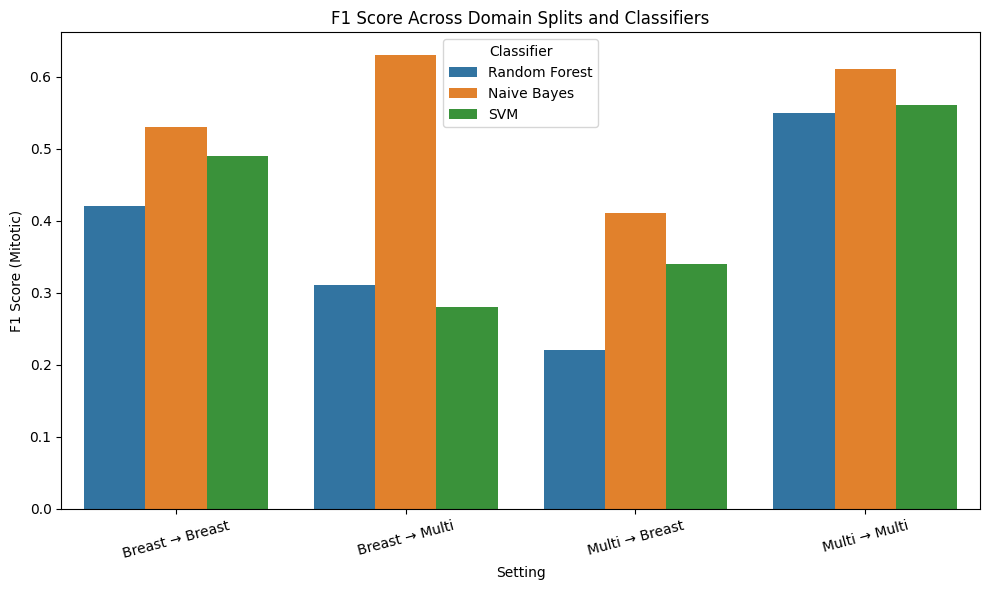

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

data = {
    'Setting': [
        'Breast → Breast', 'Breast → Multi',
        'Multi → Breast', 'Multi → Multi'
    ] * 3,
    'Classifier': ['Random Forest']*4 + ['Naive Bayes']*4 + ['SVM']*4,
    'F1': [
        0.42, 0.31, 0.22, 0.55,  # Random Forest
        0.53, 0.63, 0.41, 0.61,  # Naive Bayes
        0.49, 0.28, 0.34, 0.56   # SVM
    ]
}

df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='Setting', y='F1', hue='Classifier')
plt.title("F1 Score Across Domain Splits and Classifiers")
plt.ylabel("F1 Score (Mitotic)")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


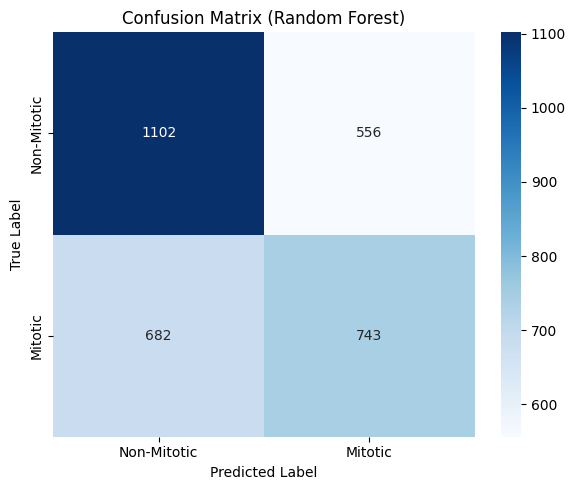

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Confusion matrix
cm = np.array([[1102  ,556],
 [ 682  ,743]])

# Class labels
labels = ['Non-Mitotic', 'Mitotic']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Random Forest)')
plt.tight_layout()
plt.show()
